In [53]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd

import shutil
import sys
import os.path

if not shutil.which("pyomo"):
    !pip install -q pyomo
    assert(shutil.which("pyomo"))

if not (shutil.which("cbc") or os.path.isfile("cbc")):
    if "google.colab" in sys.modules:
        !apt-get install -y -qq coinor-cbc
    else:
        try:
            !conda install -c conda-forge coincbc
        except:
            pass

assert(shutil.which("cbc") or os.path.isfile("cbc"))
from pyomo.environ import *
from pyomo.gdp import *

In [54]:
#пример 3. длительность всех операций = 1
TASKS = {
    # Для J1
    ('J_1', 'M_1') : {'dur': 1, 'prec': None},  # Первая операция J1 на M1
    ('J_1', 'M_3') : {'dur': 1, 'prec': ('J_1', 'M_1')},  # После M1 идет M3
    ('J_1', 'M_2') : {'dur': 1, 'prec': ('J_1', 'M_3')},  # После M3 идет M2
    ('J_1_1', 'M_1') : {'dur': 1, 'prec': ('J_1', 'M_2')},  # После M2 снова идет M1

    # Для J2
    ('J_2', 'M_2') : {'dur': 1, 'prec': None},  # Первая операция J2 на M2
    ('J_2', 'M_3') : {'dur': 1, 'prec': ('J_2', 'M_2')},  # После M2 идет M3

    # Для J3
    ('J_3', 'M_3') : {'dur': 1, 'prec': None},  # Первая операция J3 на M3
    ('J_3', 'M_1') : {'dur': 1, 'prec': ('J_3', 'M_3')},  # После M3 идет M1

    # Для J4
    ('J_4', 'M_1') : {'dur': 1, 'prec': None},  # Первая операция J4 на M1
    ('J_4', 'M_3') : {'dur': 1, 'prec': ('J_4', 'M_1')},  # После M1 идет M3
    ('J_4_1', 'M_1') : {'dur': 1, 'prec': ('J_4', 'M_3')},  # После M3 снова идет M1

    # Для J5
    ('J_5', 'M_3') : {'dur': 1, 'prec': None},  # Первая операция J5 на M3
    ('J_5', 'M_1') : {'dur': 1, 'prec': ('J_5', 'M_3')},  # После M3 идет M1
    ('J_5', 'M_2') : {'dur': 1, 'prec': ('J_5', 'M_1')},  # После M1 идет M2
    ('J_5_1', 'M_3') : {'dur': 1, 'prec': ('J_5', 'M_2')}  # После M2 снова идет M3
}


In [55]:
def jobshop_model(TASKS):

    model = ConcreteModel()

    # tasks is a two dimensional set of (j,m) constructed from the dictionary keys
    model.TASKS = Set(initialize = TASKS.keys(), dimen=2)

    # the set of jobs is constructed from a python set
    model.JOBS = Set(initialize = list(set([j for (j,m) in model.TASKS])))

    # set of machines is constructed from a python set
    model.MACHINES = Set(initialize = list(set([m for (j,m) in model.TASKS])))

    # the order of tasks is constructed as a cross-product of tasks and filtering
    model.TASKORDER = Set(initialize = model.TASKS * model.TASKS, dimen=4,
        filter = lambda model, j, m, k, n: (k,n) == TASKS[(j,m)]['prec'])

    # the set of disjunctions is cross-product of jobs, jobs, and machines
    model.DISJUNCTIONS = Set(initialize = model.JOBS * model.JOBS * model.MACHINES, dimen=3,
        filter = lambda model, j, k, m: j < k and (j,m) in model.TASKS and (k,m) in model.TASKS)

    # load duration data into a model parameter for later access
    model.dur = Param(model.TASKS, initialize=lambda model, j, m: TASKS[(j,m)]['dur'])

    # establish an upper bound on makespan
    ub = sum([model.dur[j, m] for (j,m) in model.TASKS])

    # create decision variables
    model.makespan = Var(bounds=(0, ub))
    model.start = Var(model.TASKS, bounds=(0, ub))

    model.objective = Objective(expr = model.makespan, sense = minimize)

    model.finish = Constraint(model.TASKS, rule=lambda model, j, m:
        model.start[j,m] + model.dur[j,m] <= model.makespan)

    model.preceding = Constraint(model.TASKORDER, rule=lambda model, j, m, k, n:
        model.start[k,n] + model.dur[k,n] <= model.start[j,m])

    model.disjunctions = Disjunction(model.DISJUNCTIONS, rule=lambda model,j,k,m:
        [model.start[j,m] + model.dur[j,m] <= model.start[k,m],
         model.start[k,m] + model.dur[k,m] <= model.start[j,m]])

    TransformationFactory('gdp.hull').apply_to(model)
    return model

jobshop_model(TASKS)

In [56]:
jobs_my = {
    'J_1_1' : 'J_1',
    'J_4_1' : 'J_4',
    'J_5_1' : 'J_5',
    'J_1' : 'J_1',
    'J_2' : 'J_2',
    'J_3' : 'J_3',
    'J_4' : 'J_4',
    'J_5' : 'J_5'
}

print(jobs_my.get("J_4"))

J_4


In [57]:
def jobshop_solve(model):
    SolverFactory('cbc').solve(model)

    results = [{'Job': jobs_my.get(j),
                'Machine': m,
                'Start': model.start[j, m](),
                'Duration': model.dur[j,m],
                'Finish': model.start[(j, m)]() + model.dur[j,m]}
               for j,m in model.TASKS]
    return results

def jobshop(TASKS):
    return jobshop_solve(jobshop_model(TASKS))

results = jobshop(TASKS)
results

[{'Job': 'J_1', 'Machine': 'M_1', 'Start': 0.0, 'Duration': 1, 'Finish': 1.0},
 {'Job': 'J_1', 'Machine': 'M_3', 'Start': 2.0, 'Duration': 1, 'Finish': 3.0},
 {'Job': 'J_1', 'Machine': 'M_2', 'Start': 3.0, 'Duration': 1, 'Finish': 4.0},
 {'Job': 'J_1', 'Machine': 'M_1', 'Start': 5.0, 'Duration': 1, 'Finish': 6.0},
 {'Job': 'J_2', 'Machine': 'M_2', 'Start': 0.0, 'Duration': 1, 'Finish': 1.0},
 {'Job': 'J_2', 'Machine': 'M_3', 'Start': 5.0, 'Duration': 1, 'Finish': 6.0},
 {'Job': 'J_3', 'Machine': 'M_3', 'Start': 1.0, 'Duration': 1, 'Finish': 2.0},
 {'Job': 'J_3', 'Machine': 'M_1', 'Start': 3.0, 'Duration': 1, 'Finish': 4.0},
 {'Job': 'J_4', 'Machine': 'M_1', 'Start': 2.0, 'Duration': 1, 'Finish': 3.0},
 {'Job': 'J_4', 'Machine': 'M_3', 'Start': 3.0, 'Duration': 1, 'Finish': 4.0},
 {'Job': 'J_4', 'Machine': 'M_1', 'Start': 4.0, 'Duration': 1, 'Finish': 5.0},
 {'Job': 'J_5', 'Machine': 'M_3', 'Start': 0.0, 'Duration': 1, 'Finish': 1.0},
 {'Job': 'J_5', 'Machine': 'M_1', 'Start': 1.0, 'Dur

In [58]:
schedule = pd.DataFrame(results)

print('\nSchedule by Job')
print(schedule.sort_values(by=['Job','Start']).set_index(['Job', 'Machine']))

print('\nSchedule by Machine')
print(schedule.sort_values(by=['Machine','Start']).set_index(['Machine', 'Job']))


Schedule by Job
             Start  Duration  Finish
Job Machine                         
J_1 M_1        0.0         1     1.0
    M_3        2.0         1     3.0
    M_2        3.0         1     4.0
    M_1        5.0         1     6.0
J_2 M_2        0.0         1     1.0
    M_3        5.0         1     6.0
J_3 M_3        1.0         1     2.0
    M_1        3.0         1     4.0
J_4 M_1        2.0         1     3.0
    M_3        3.0         1     4.0
    M_1        4.0         1     5.0
J_5 M_3        0.0         1     1.0
    M_1        1.0         1     2.0
    M_2        2.0         1     3.0
    M_3        4.0         1     5.0

Schedule by Machine
             Start  Duration  Finish
Machine Job                         
M_1     J_1    0.0         1     1.0
        J_5    1.0         1     2.0
        J_4    2.0         1     3.0
        J_3    3.0         1     4.0
        J_4    4.0         1     5.0
        J_1    5.0         1     6.0
M_2     J_2    0.0         1     1.0


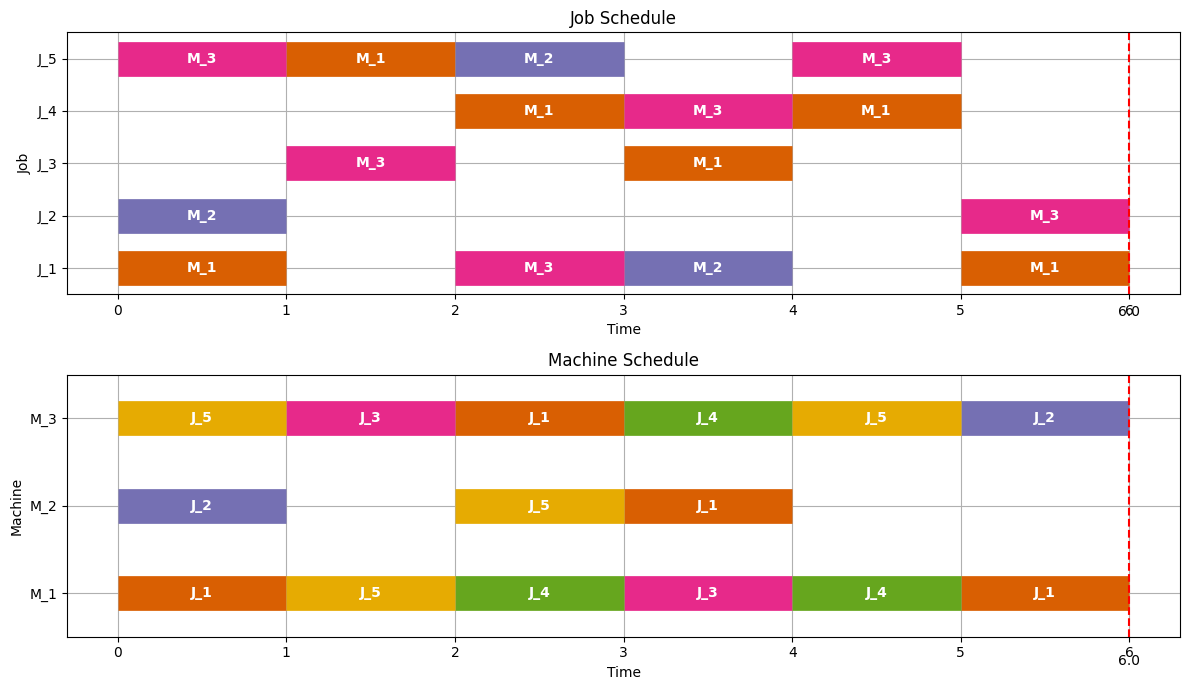

In [59]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

def visualize(results):

    # Преобразование данных в DataFrame
    schedule = pd.DataFrame(results)

    # Проверка на наличие необходимых столбцов
    required_columns = ['Job', 'Machine', 'Start', 'Finish']
    for col in required_columns:
        if col not in schedule.columns:
            raise ValueError(f"Столбец {col} отсутствует в данных.")

    # Проверка на наличие значений в столбцах Start и Finish
    if schedule['Start'].isnull().any() or schedule['Finish'].isnull().any():
        raise ValueError("В столбцах 'Start' или 'Finish' есть пустые значения.")

    # Получаем уникальные задания и машины
    JOBS = sorted(schedule['Job'].unique())
    MACHINES = sorted(schedule['Machine'].unique())
    makespan = schedule['Finish'].max()

    # Настройки стилей для графика
    bar_style = {'alpha': 1.0, 'lw': 25, 'solid_capstyle': 'butt'}
    text_style = {'color': 'white', 'weight': 'bold', 'ha': 'center', 'va': 'center'}
    colors = mpl.cm.Dark2.colors

    # Сортировка по Job и Start для правильного отображения
    schedule = schedule.sort_values(by=['Job', 'Start'])

    # Создание графиков
    fig, ax = plt.subplots(2, 1, figsize=(12, 5 + (len(JOBS) + len(MACHINES)) / 4))

    # Построение графика для каждого задания
    for jdx, j in enumerate(JOBS, 1):
        for mdx, m in enumerate(MACHINES, 1):
            # Фильтрация данных для текущего Job и Machine
            filtered_schedule = schedule[(schedule['Job'] == j) & (schedule['Machine'] == m)]
            if not filtered_schedule.empty:
                for _, row in filtered_schedule.iterrows():
                    xs = row['Start']
                    xf = row['Finish']
                    ax[0].plot([xs, xf], [jdx] * 2, c=colors[mdx % 7], **bar_style)
                    ax[0].text((xs + xf) / 2, jdx, m, **text_style)
                    ax[1].plot([xs, xf], [mdx] * 2, c=colors[jdx % 7], **bar_style)
                    ax[1].text((xs + xf) / 2, mdx, j, **text_style)

    # Настройка графика заданий
    ax[0].set_title('Job Schedule')
    ax[0].set_ylabel('Job')

    # Настройка графика машин
    ax[1].set_title('Machine Schedule')
    ax[1].set_ylabel('Machine')

    for idx, s in enumerate([JOBS, MACHINES]):
        ax[idx].set_ylim(0.5, len(s) + 0.5)
        ax[idx].set_yticks(range(1, 1 + len(s)))
        ax[idx].set_yticklabels(s)
        ax[idx].text(makespan, ax[idx].get_ylim()[0] - 0.2, "{0:0.1f}".format(makespan), ha='center', va='top')
        ax[idx].plot([makespan] * 2, ax[idx].get_ylim(), 'r--')
        ax[idx].set_xlabel('Time')
        ax[idx].grid(True)

    # Применение настроек оформления
    fig.tight_layout()

# Пример вызова визуализации
visualize(results)
